In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def f(x):
    return 3*x**2  - 4*x + 5

In [9]:
f(3.0)

20.0

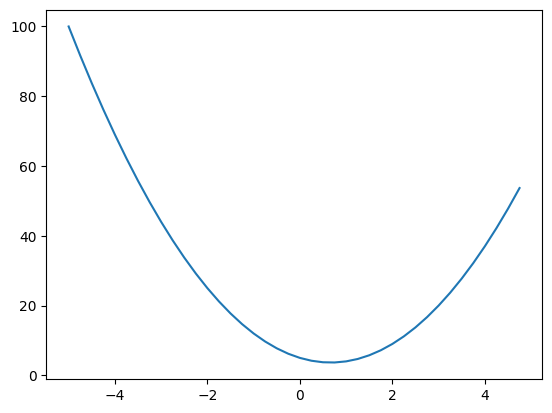

In [10]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
plt.plot(xs, ys)

In [11]:
h = 0.00001
x = 2/3
(f(x + h) - f(x))/h

3.0000002482211127e-05

In [12]:
# adding more than one term
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [13]:
# get derivative of d with respect to a
h = 0.001
d1 = a*b + c
a += h
d2 = a*b + c
print((d2 - d1)/h) # should be very close to b

-3.0000000000001137


In [14]:
# get derivative of d with respect to b
a = 2.0
b = -3.0
c = 10.0
b += h
d2 = a*b + c
print((d2 - d1)/h) # should be very close to a

1.9999999999997797


In [15]:
# get derivative of d with respect to c
a = 2.0
b = -3.0
c = 10.0
c += h
d2 = a*b + c
print((d2 - d1)/h) # should be very close to 1

0.9999999999994458


In [16]:
from numbers import Number
from typing import Tuple
from collections import deque

class Value:
    def __init__ (self, data: Number, _children:Tuple=(), _op:str='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
 
    def __pow__(self, other) -> 'Value':
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
          
        return out
      
    def __rmul__(self, other) -> 'Value':
        return self * other

    def __truediv__(self, other) -> 'Value':
        return self * other**-1
 
    def __neg__ (self) -> 'Value':
        return self * -1
    
    def __sub__(self, other) -> 'Value':
        return self + (-other)

    def __radd__(self, other) -> 'Value':
        return self + other
    
   
    def tanh (self) -> 'Value':
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2)* out.grad
        out._backward = _backward
        
        return out

    def exp (self) -> 'Value':

        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward (self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
            
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [17]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [18]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | dL/d%s = %.4f }" % (n.label, n.data, n.label, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

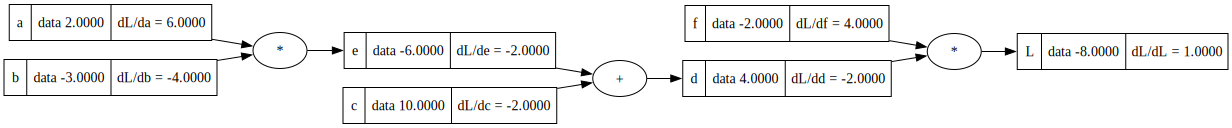

In [19]:
L.backward()
draw_dot(L)

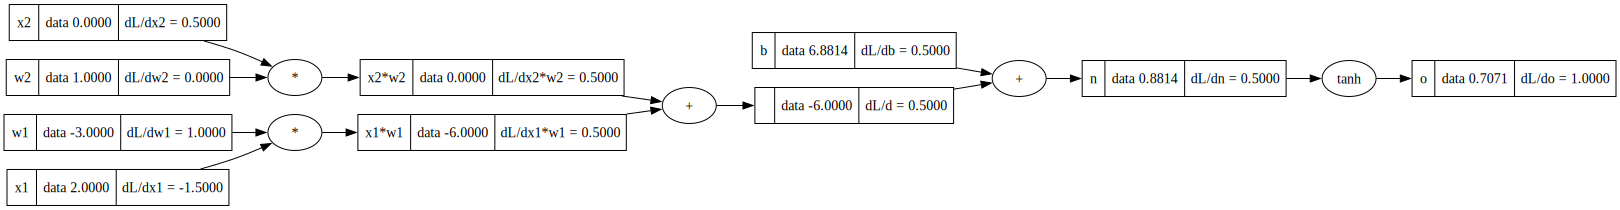

In [20]:
# more complex example representing a neural network
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# x1*w1 + x2*w2 + b
b = Value(6.88137358, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
n = x1w1 + x2w2 + b; n.label = 'n'
# tanh(n)
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)


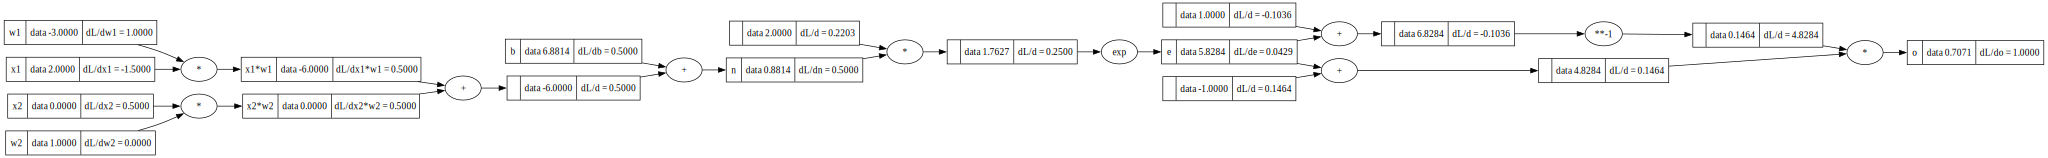

In [21]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# x1*w1 + x2*w2 + b
b = Value(6.88137358, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
n = x1w1 + x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)

In [22]:
# implement math expressions with pytorch
import torch
x1 = torch.tensor([2.0]).double()               ; x1.requires_grad = True # since these values are scalars, we need to set requires_grad to True
x2 = torch.tensor([0.0]).double()              ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()             ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()           ; w2.requires_grad = True
b = torch.tensor([6.88137358]).double()       ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.data.item() # get the value of o
o.backward()

print(x1.grad.item()) # get the gradient of o with respect to x1
print(w1.grad.item()) # get the gradient of o with respect to w1
print(x2.grad.item()) # get the gradient of o with respect to x2
print(w2.grad.item()) # get the gradient of o with respect to w2
o.item()

-1.5000003851533106
1.0000002567688737
0.5000001283844369
0.0


0.7071066904050358

In [31]:
# implement neural network with micrograd
import random
from typing import List

class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x) -> Value:
        act = sum ([wi*xi for wi, xi in zip(self.w, x)], self.b) 
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x) -> List[Value]: 
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    def __init__(self, nin: int, nouts: List[int]) -> None:
        szs = [nin] + nouts
        self.layers = [Layer(szs[i], szs[i+1]) for i in range(len(szs) - 1)]
    
    def __call__(self, x) -> Value:
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0]
n = MLP(3, [4, 4, 1])

Value(data=-0.5781429513352444)

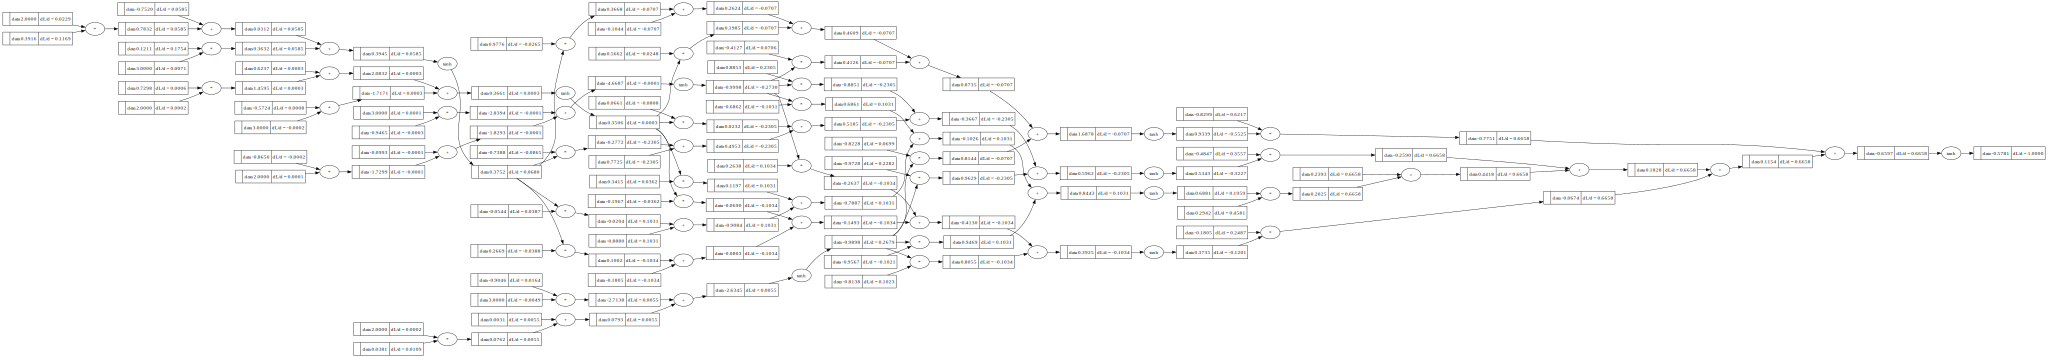

In [33]:
out = (n(x))
out.backward()
draw_dot(out)